In [340]:
import numpy as np
from celluloid import Camera

class Agent:  
      def __init__(self,position,speed):
            self.position = np.array(position)
            self.speed = speed

def agent_interaction(agents):
    k=len(agents)
    x=np.zeros(shape=(k,k))
    for i in range(k):
        for j in range(k):
            x[i,j]=np.sum((agents[i].position-agents[j].position)**2)
    return x

def group_density(agents):
    gdd={}
    X=agent_interaction(agents)
    for i in range(len(agents)):
        p=sum(k > 0.1 for k in X[i,:])
        gdd[i+1]=p
    gdd2= dict(sorted(gdd.items(), key=lambda x: x[1], reverse=True))
    return list(gdd2.keys())
            
class Prey(Agent):
    def escape(self,agents):
        target1=[0,0]
        target1[0] = np.mean([a.position[0] for a in agents if type(a)==Prey])# and a!=self]) 
        target1[1] = np.mean([a.position[1] for a in agents if type(a)==Prey])# and a!=self]) 
        #l=[]
        #for a in agents:
        #    if type(a)==Prey and a!=self:
        #        l.append(np.sum((self.position-a.position)**2))
        #l=np.asarray(l)
        #target1 = agents[np.argmin(l)+1]
        target2= [a for a in agents if type(a)==Predator]
        vector1 = target1 - self.position
        vector2 = target2[0].position - self.position
        vector1 = vector1 / np.sqrt(np.sum(vector1**2))
        vector2 = vector2 / np.sqrt(np.sum(vector2**2))
        self.position = self.position - (vector2) * self.speed
        
    def follow_leader(self,agents):
        #randomly pick *another* Prey
        #target = np.random.choice([a for a in agents if type(a)==Prey and a!=self])
        #target=[0,0]
        #target[0] = np.mean([a.position[0] for a in agents if type(a)==Prey and a!=self]) 
        #target[1] = np.mean([a.position[1] for a in agents if type(a)==Prey and a!=self]) 
        target = agents[1]
        vector = target.position - self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + vector * self.speed #+ (np.random.rand(2)-0.5)
        #keeps the Prey in a 5x5 box
        #self.position[self.position<0] = 0
        #self.position[self.position>5] = 5    
    
    def leader_move(self,agents):
        target= [a for a in agents if type(a)==Predator]
        vector = target[0].position - self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position - (vector) * self.speed
    
    def pattern1(self,agents):
        target1 = agents[1] 
        #l=[]
        #for a in agents:
        #    if type(a)==Prey and a!=self:
        #        l.append(np.sum((self.position-a.position)**2))
        #l=np.asarray(l)
        #target1 = agents[np.argmin(l)+1] # nearest neighbour
        target2= [a for a in agents if type(a)==Predator]
        vector1 = target1.position - self.position
        vector2 = target2[0].position - self.position
        vector1 = vector1 / np.sqrt(np.sum(vector1**2))
        vector2 = vector2 / np.sqrt(np.sum(vector2**2))
        self.position = self.position - (0.5*vector1 + 1.5*vector2) * self.speed
    
    def pattern2(self, agents, neighbours):
        target1=[0,0]
        target1[0] = np.mean([a.position[0] for a in neighbours if type(a)==Prey and a!=self]) 
        target1[1] = np.mean([a.position[1] for a in neighbours if type(a)==Prey and a!=self]) 
        target2= [a for a in agents if type(a)==Predator]
        vector1 = target1 - self.position
        vector1 = vector1 / np.sqrt(np.sum(vector1**2))
        vector2 = target2[0].position - self.position
        vector2 = vector2 / np.sqrt(np.sum(vector2**2))
        self.position = self.position + (vector1-vector2) * self.speed
                
        
class Predator(Agent):
    def hunt(self,agents):  # Attack the closest prey
        l=[]
        for a in agents:
            if type(a)==Prey:
                l.append(np.sum((self.position-a.position)**2))
        l=np.asarray(l)
        target = agents[np.argmin(l)+1]
        vector= target.position-self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + (vector) * self.speed        

    def move(self,agents):
        vector = np.array([0,0])
        for a in agents:
            vector = a.position - self.position
            if (np.sum(vector**2)<3**2):
                vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + vector * self.speed
        #keeps the Predator in a 5x5 box
        self.position[self.position<0] = 0
        self.position[self.position>5] = 5 
    
    def slow_down(self,agents):
        l=[]
        for a in agents:
            if type(a)==Prey:
                l.append(np.sum((self.position-a.position)**2))
        l=np.asarray(l)
        target = agents[np.argmin(l)+1]
        vector= target.position-self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + 0.5*(vector) * self.speed 
        
    def hunt_group(self,agents): # Attack the dense group
        target=[0,0]
        target[0] = np.mean([a.position[0] for a in agents if type(a)==Prey]) 
        target[1] = np.mean([a.position[1] for a in agents if type(a)==Prey]) 
        vector= target-self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + (vector) * self.speed
        
    def hunt_dense(self,agents):
        dense_prey = group_density(agents[1:])
        target =agents[dense_prey[0]]
        vector= target.position-self.position
        vector = vector / np.sqrt(np.sum(vector**2))
        self.position = self.position + (vector) * self.speed
        
def nearest_neighbours(preyX):
    temp_dict=dict()
    ab= list(range((preyX.shape[0])))
    for i in ab:
        distances=preyX[i,:]
        group_of= 7
        nearest = np.argsort(distances)[:group_of]
        nearest = list(nearest)
        del nearest[0]
        for pq in nearest:
            if pq in temp_dict: nearest.remove(pq)
            if pq in ab: ab.remove(pq)
        temp_dict[i] = nearest
    return temp_dict

In [341]:
agents=[Predator([0,0],0.07)]#, Prey([1,3],0.05), Prey([2,1],0.05), Prey([1.5,1.5],0.05)]
np.random.seed(0)
for i in range(50):
    agents.append(Prey(np.random.rand(2)*3,0.055))

MovieWriter ffmpeg unavailable; using Pillow instead.


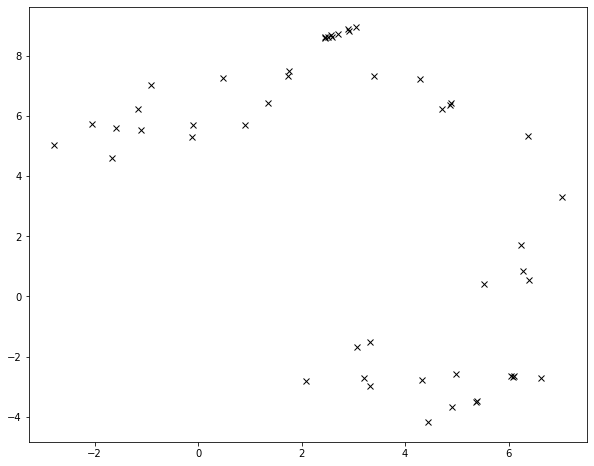

In [342]:
import matplotlib.pyplot as plt
#%matplotlib inline
k=100
kk=-3
fig = plt.figure(figsize=(10,8))
camera = Camera(fig)
for it in range(k):
    X=agent_interaction(agents)
    risk=np.argmin(X[0,1:])
    agents2=agents.copy()
    if X[0,risk+1]<0.005:   # Eaten
        del agents[risk+1]
        kk=it
    if X[0,risk+1]<0.2: #panic
        agents2[risk+1].escape(agents)
        if it>kk+5: agents2[0].hunt(agents)
        del agents2[risk+1]
    else:
        if it<kk+5:
            agents2[0].slow_down(agents)
        else:
            if it<=75: agents2[0].hunt_group(agents)
    agents2[1].leader_move(agents)
    if it<51:
        for a in agents2[2:]: 
            a.follow_leader(agents2)
    if it>50 and it<76:
        for a in agents2[2:]: 
            a.pattern1(agents)
            #a.follow_leader(agents2)
    #if it>90:
    #    for a in agents2[2:]: a.escape(agents)
    if it>75:# and it<100:
        agents2[0].hunt_dense(agents)
        p = nearest_neighbours(X[1:,1:])
        index=0
        for i in list(p.keys()):
            indices= p[i]
            agents2[i+1].pattern2(agents,np.asarray(agents)[indices])
            for j in indices: agents2[j+1].escape(agents)
        #for a in agents2[1:]: 
        #    #a.follow_leader(agents2)
        #    if index in p: 
        #        indices= p[index]
        #        a.pattern2(agents2,np.asarray(agents2)[indices])
        #    index+=1
  #plot there new positions
    for a in agents:
        if type(a)==Predator:
            plt.plot(a.position[0],a.position[1],'or')#,alpha=it/k) 
            camera.snap()
        if type(a)==Prey:
            plt.plot(a.position[0],a.position[1],'xk')#,alpha=it/k)
camera.snap()    

animation = camera.animate()
animation.save('sim.gif')
from IPython.display import HTML
HTML(animation.to_jshtml())

In [314]:
len(agents2)